In [35]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import itertools
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
class MaskedLM(nn.Module):
    def __init__(self, num_codes, embed_dim=256, num_heads=8, hidden_dim=512, num_layers=4, dropout=0.1):
        super(MaskedLM, self).__init__()
        self.embedding = nn.Embedding(num_codes, embed_dim)
        
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embed_dim, num_codes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        logits = self.output_layer(x)
        return logits

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [7]:
def mask_tokens(inputs, vocab_size, mask_token_id, pad_token_id=0, mlm_probability=0.15):
    labels = inputs.clone()

    probability_matrix = torch.full(labels.shape, mlm_probability)
    probability_matrix.masked_fill_(inputs == pad_token_id, 0.0)
    
    masked_indices = torch.bernoulli(probability_matrix).bool()
    
    labels[~masked_indices] = -100
    
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = mask_token_id
    
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_tokens = torch.randint(1, vocab_size-1, labels.shape, dtype=torch.long, device=inputs.device)
    inputs[indices_random] = random_tokens[indices_random]
    
    
    return inputs, labels

In [34]:
def compute_embedding_similarity(model, id2icd):
    weight_matrix = model.embedding.weight.detach().cpu()

    similarity_matrix = cosine_similarity(weight_matrix.numpy())
    
    valid_indices = list(range(1, len(id2icd) - 1))
    codes = [id2icd[i] for i in valid_indices]

    similarity_df = pd.DataFrame(
        similarity_matrix[1:-1, 1:-1],
        index=codes,
        columns=codes
    )
    return similarity_df

In [9]:
def train_model(model, train_dataloader, val_dataloader, vocab_size, mask_token_id, 
                pad_token_id=0, epochs=20, lr=5e-4, device="cuda", patience=3):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//2, factor=0.5, verbose=True)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    best_val_loss = float('inf')
    no_improve_count = 0
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0
        all_train_preds, all_train_labels = [], []
        
        for batch in train_dataloader:
            masked_inputs, labels = mask_tokens(batch.clone(), vocab_size, mask_token_id, pad_token_id)
            masked_inputs, labels = masked_inputs.to(device), labels.to(device)
            
            logits = model(masked_inputs)
            loss = loss_fn(logits.view(-1, vocab_size), labels.view(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            
            mask = labels != -100
            if mask.sum() > 0:
                preds = logits.argmax(dim=-1)
                correct = (preds[mask] == labels[mask]).sum().item()
                total_train_correct += correct
                total_train_tokens += mask.sum().item()
                all_train_preds.extend(preds[mask].cpu().numpy())
                all_train_labels.extend(labels[mask].cpu().numpy())
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = total_train_correct / total_train_tokens if total_train_tokens > 0 else 0.0
        train_macro_precision = precision_score(all_train_labels, all_train_preds, average='macro', zero_division=0)
        
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for batch in val_dataloader:
                masked_inputs, labels = mask_tokens(batch.clone(), vocab_size, mask_token_id, pad_token_id)
                masked_inputs, labels = masked_inputs.to(device), labels.to(device)

                logits = model(masked_inputs)
                loss = loss_fn(logits.view(-1, vocab_size), labels.view(-1))
                total_val_loss += loss.item()
                
                mask = labels != -100
                if mask.sum() > 0:
                    preds = logits.argmax(dim=-1)
                    correct = (preds[mask] == labels[mask]).sum().item()
                    total_val_correct += correct
                    total_val_tokens += mask.sum().item()
                    all_val_preds.extend(preds[mask].cpu().numpy())
                    all_val_labels.extend(labels[mask].cpu().numpy())
                
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_val_correct / total_val_tokens if total_val_tokens > 0 else 0.0
        val_macro_precision = precision_score(all_val_labels, all_val_preds, average='macro', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, P(M): {train_macro_precision:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, P(M): {val_macro_precision:.4f}")
        
        scheduler.step(avg_val_loss)
        
        if not math.isnan(avg_val_loss) and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_count = 0
            print(f"New best validation loss: {best_val_loss:.4f}.")
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break
    
    return model

In [10]:
def compute_euclidean_distance(model, id2icd):
    weight_matrix = model.embedding.weight.detach().cpu()
    distance_matrix = torch.cdist(weight_matrix, weight_matrix, p=2)
    valid_indices = list(range(1, len(id2icd) - 1))
    codes = [id2icd[i] for i in valid_indices]

    distance_df = pd.DataFrame(
        distance_matrix.numpy()[1:-1, 1:-1],
        index=codes,
        columns=codes
    )

    return distance_df

In [11]:
class ICDDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = [torch.tensor(s, dtype=torch.long) for s in sequences]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

def collate_fn(batch):
    return pad_sequence(batch, batch_first=True, padding_value=0)

In [12]:
df = pd.read_csv('prepared_data.csv', index_col=0)
df = df.sort_values(["subject_id", "admittime", "seq_num"])
df['seq_num'] = df.groupby('subject_id').cumcount() + 1

In [13]:
unique_icds = df["category"].unique()
print(f"Уникальных ICD кодов: {len(unique_icds)}")

PAD_TOKEN = "[PAD]"
PAD_TOKEN_ID = 0
icd2id = {code: idx for idx, code in enumerate(unique_icds, start=1)}
icd2id[PAD_TOKEN] = PAD_TOKEN_ID

MASK_TOKEN = "[MASK]"
MASK_TOKEN_ID = len(icd2id)
icd2id[MASK_TOKEN] = MASK_TOKEN_ID

id2icd = {idx: code for code, idx in icd2id.items()}
vocab_size = len(icd2id)

df['icd_id'] = df['category'].map(icd2id)
df = df[['subject_id', 'seq_num', 'category', 'icd_id']]

Уникальных ICD кодов: 1757


In [14]:
all_subjects = df['subject_id'].unique()
train_subjects, val_subjects = train_test_split(all_subjects, test_size=0.1, random_state=42)

print(f"Total subjects: {len(all_subjects)}")
print(f"Training subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")

Total subjects: 223291
Training subjects: 200961
Validation subjects: 22330


In [15]:
sequences_df = df.groupby('subject_id')['category'].apply(list)
train_sequences = sequences_df.loc[train_subjects].tolist()
val_sequences = sequences_df.loc[val_subjects].tolist()

max_len = 100
min_len = 5

trimmed_train_sequences = [seq[:max_len] for seq in train_sequences]
train_seq_idx = [[icd2id[code] for code in seq] for seq in trimmed_train_sequences]
train_seq_idx = [seq for seq in train_seq_idx if len(seq) >= min_len]

trimmed_val_sequences = [seq[:max_len] for seq in val_sequences]
val_seq_idx = [[icd2id[code] for code in seq] for seq in trimmed_val_sequences]
val_seq_idx = [seq for seq in val_seq_idx if len(seq) >= min_len]

train_dataset = ICDDataset(train_seq_idx)
val_dataset = ICDDataset(val_seq_idx)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MaskedLM(
    num_codes=vocab_size, 
    embed_dim=256,      
    num_layers=4,       
    num_heads=8,
    hidden_dim=512
).to(device)

In [17]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}") 

Total Trainable Parameters: 3,010,783


In [18]:
trained_model = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    vocab_size, 
    MASK_TOKEN_ID,
    pad_token_id=PAD_TOKEN_ID,
    epochs=100,
    lr=1e-4,
    patience=5,
    device=device
)

Epoch 1/100 | Train Loss: 5.0993, Acc: 0.1056, P(M): 0.0739 | Val Loss: 4.6999, Acc: 0.1418, P(M): 0.1021
New best validation loss: 4.6999.
Epoch 2/100 | Train Loss: 4.6238, Acc: 0.1486, P(M): 0.1140 | Val Loss: 4.4782, Acc: 0.1635, P(M): 0.1375
New best validation loss: 4.4782.
Epoch 3/100 | Train Loss: 4.4648, Acc: 0.1657, P(M): 0.1327 | Val Loss: nan, Acc: 0.1812, P(M): 0.1524
Epoch 4/100 | Train Loss: 4.3674, Acc: 0.1796, P(M): 0.1442 | Val Loss: 4.2515, Acc: 0.1949, P(M): 0.1703
New best validation loss: 4.2515.
Epoch 5/100 | Train Loss: 4.2873, Acc: 0.1907, P(M): 0.1605 | Val Loss: nan, Acc: 0.2060, P(M): 0.1753
Epoch 6/100 | Train Loss: 4.2183, Acc: 0.1998, P(M): 0.1651 | Val Loss: nan, Acc: 0.2194, P(M): 0.1751
Epoch 7/100 | Train Loss: 4.1524, Acc: 0.2102, P(M): 0.1696 | Val Loss: 4.0323, Acc: 0.2274, P(M): 0.1908
New best validation loss: 4.0323.
Epoch 8/100 | Train Loss: 4.0993, Acc: 0.2186, P(M): 0.1757 | Val Loss: nan, Acc: 0.2363, P(M): 0.1866
Epoch 9/100 | Train Loss: 4.

In [36]:
similarity = compute_embedding_similarity(trained_model, id2icd)

In [23]:
dist = compute_euclidean_distance(trained_model, id2icd)

In [ ]:
torch.save(trained_model.state_dict(), PATH)


In [24]:
dist

K76        R18        K74  ...        A27        Y64        Y21
K76   0.000000  21.627357  21.757608  ...  21.452614  20.929502  20.571812
R18  21.627357   0.007812  22.196760  ...  21.594997  22.299410  22.393993
K74  21.757608  22.196760   0.000000  ...  23.016949  21.410658  22.190422
B19  20.525583  19.809181  21.895420  ...  20.054506  21.650028  21.395212
J44  21.685701  21.518864  21.745092  ...  21.060963  21.115616  20.218506
..         ...        ...        ...  ...        ...        ...        ...
W85  19.502270  20.569874  21.497952  ...  21.296768  20.078449  21.310856
P07  20.506920  21.314384  21.443157  ...  19.501919  20.468954  20.733568
A27  21.452614  21.594997  23.016949  ...   0.011049  22.762764  20.966732
Y64  20.929502  22.299410  21.410658  ...  22.762764   0.005524  21.695599
Y21  20.571812  22.393993  22.190422  ...  20.966732  21.695599   0.000000

[1757 rows x 1757 columns]

In [17]:
similarity.to_csv("mlm_results_2.csv")

In [21]:
similarity = pd.read_csv("mlm_results.csv", index_col=0)

In [7]:
np.fill_diagonal(similarity.values, 0)

In [37]:
similarity

K76       R18       K74  ...       A27       Y64       Y21
K76  1.000000 -0.010119  0.032229  ...  0.003242  0.043663  0.090171
R18 -0.010119  1.000000  0.014086  ...  0.012662 -0.061047 -0.054134
K74  0.032229  0.014086  1.000000  ... -0.063101  0.073509  0.018710
B19  0.022543  0.111733 -0.025295  ...  0.086719 -0.073716 -0.031809
J44 -0.043801 -0.004149  0.029556  ...  0.035326  0.022505  0.117558
..        ...       ...       ...  ...       ...       ...       ...
W85  0.097035  0.019966 -0.009740  ... -0.054153  0.055374 -0.047246
P07 -0.038539 -0.093928 -0.041764  ...  0.082780 -0.020504 -0.029440
A27  0.003242  0.012662 -0.063101  ...  1.000000 -0.108785  0.073332
Y64  0.043663 -0.061047  0.073509  ... -0.108785  1.000000  0.000049
Y21  0.090171 -0.054134  0.018710  ...  0.073332  0.000049  1.000000

[1757 rows x 1757 columns]

In [24]:
len(similarity)

1542646

In [38]:
sorted_codes = sorted(similarity.index)

sorted_similarity = similarity.loc[sorted_codes, sorted_codes]

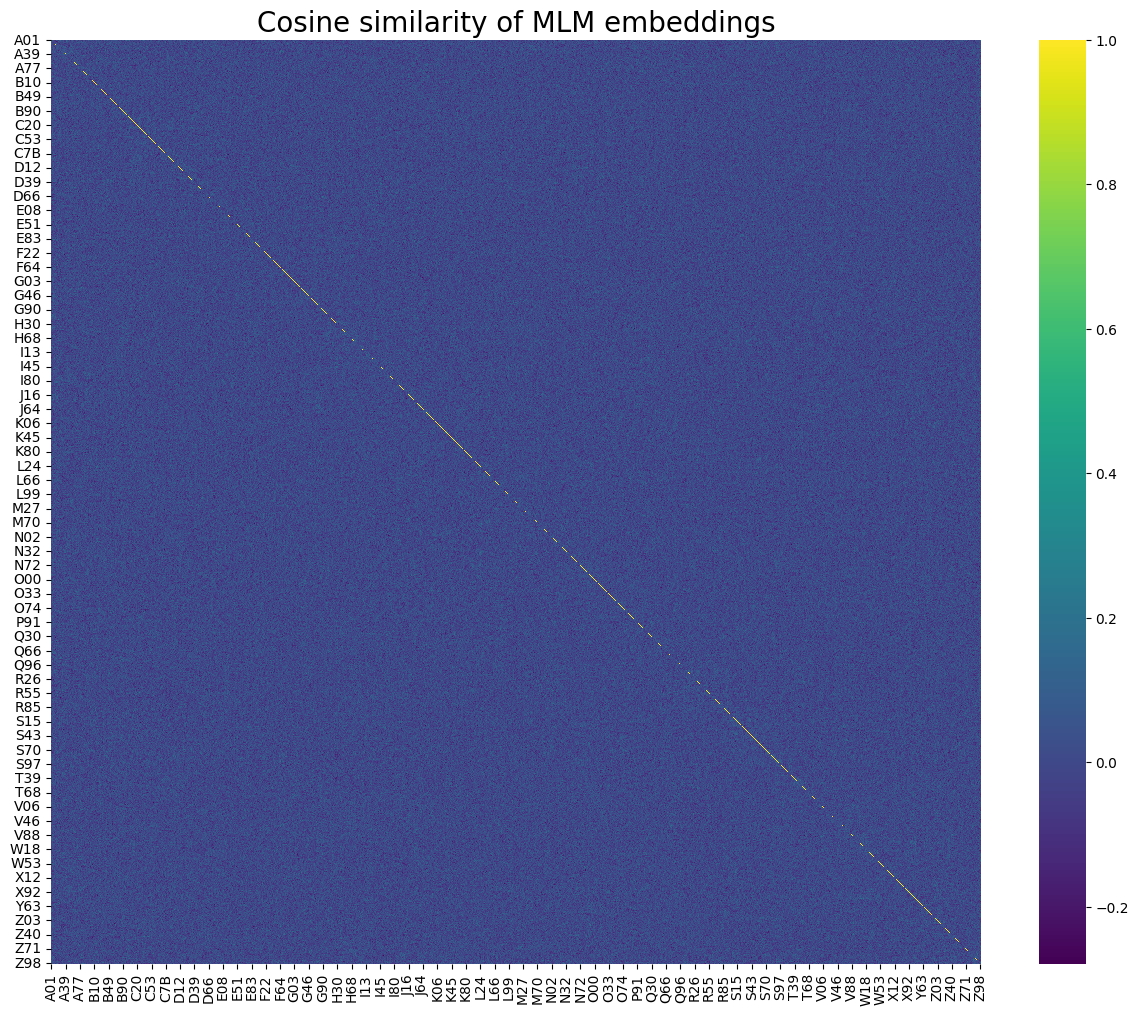

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

name = "Cosine similarity of MLM embeddings"

plt.figure(figsize=(15,12))
sns.heatmap(sorted_similarity, annot=False, cmap="viridis")
plt.title(name, fontsize=20)
plt.savefig(f'mlm.jpg', dpi=300, bbox_inches='tight')

In [32]:
sorted_codes = sorted(dist.index)

sorted_dist = dist.loc[sorted_codes, sorted_codes]

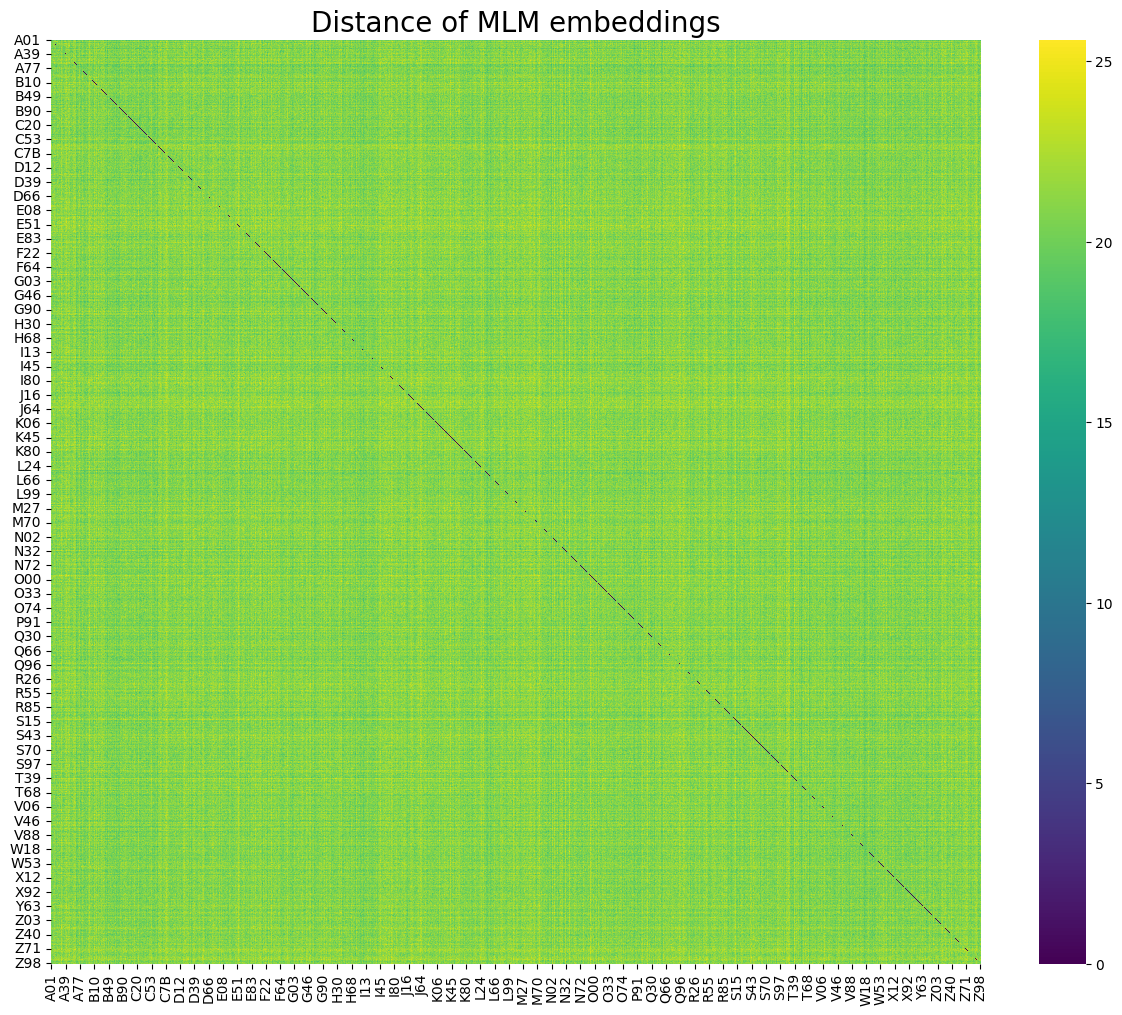

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

name = "Distance of MLM embeddings"

plt.figure(figsize=(15,12))
sns.heatmap(sorted_dist, annot=False, cmap="viridis")
plt.title(name, fontsize=20)
plt.savefig(f'mlm_dist.jpg', dpi=300, bbox_inches='tight')

In [40]:
def top_n_pairs(similarity_df, n=10):
    df_long = similarity_df.stack().reset_index()
    df_long.columns = ["icd_1", "icd_2", "similarity"]

    df_long = df_long[df_long["icd_1"] != df_long["icd_2"]]

    df_long = df_long[df_long["icd_1"] < df_long["icd_2"]]

    df_top = df_long.sort_values("similarity", ascending=False).head(n)
    return df_top

In [42]:
top_10 = top_n_pairs(similarity, n=10)
print(top_10)

        icd_1 icd_2  similarity
2051672   H92   S87    0.292885
1652265   B30   K05    0.279159
2854373   A21   H16    0.276818
295446    G40   R15    0.272226
532434    G51   R21    0.270793
174269    E46   K40    0.268423
1973873   C10   F23    0.268267
1347246   C96   L56    0.266230
2044307   F68   O47    0.266067
608365    Q23   Z09    0.264116
